In [2]:
from Halite import *
from paleopy import *

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/fefe/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


/home/fefe/Thesi/all_you_need/geant/Halite.py:186: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  Num[i] += quad(func, E[i], E[i+1], epsrel=1e-8)[0]*time*arr_time[j] #quad per integrare la funzione di flusso nell'intervallo, moltiplica per il tempo e accumula i risultati in Num
/home/fefe/Thesi/all_you_need/geant/Halite.py:193: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  Num[i+8] += quad(func, E[i], E[i+1], epsrel=1e-8)[0]*time*arr_time[j] # quad permette di calcolare l'integrale definito di una funzione in un intervallo specificato


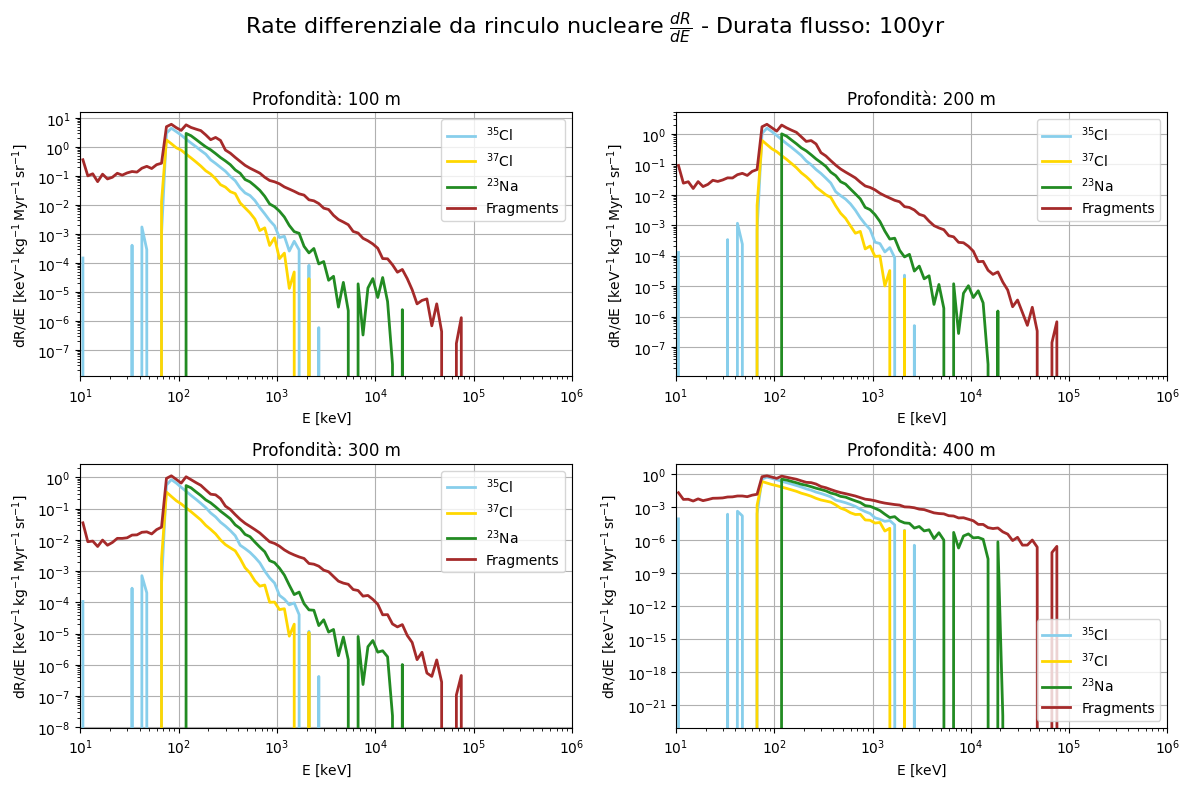

/home/fefe/Thesi/all_you_need/geant/Halite.py:200: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  Num[i+15] += quad(func, E[i], E[i+1], epsrel=1e-8)[0]*time*arr_time[j] #quad restituisce il risultato dell'integrale e l'errore


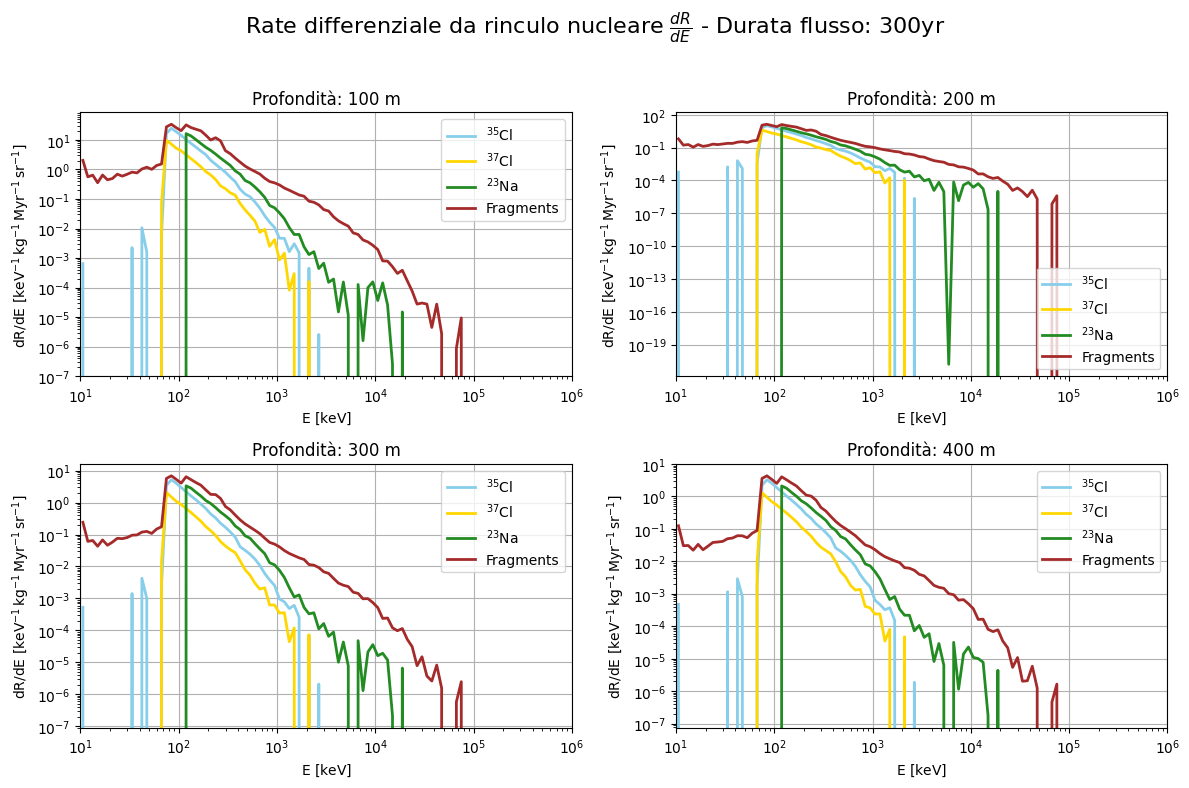

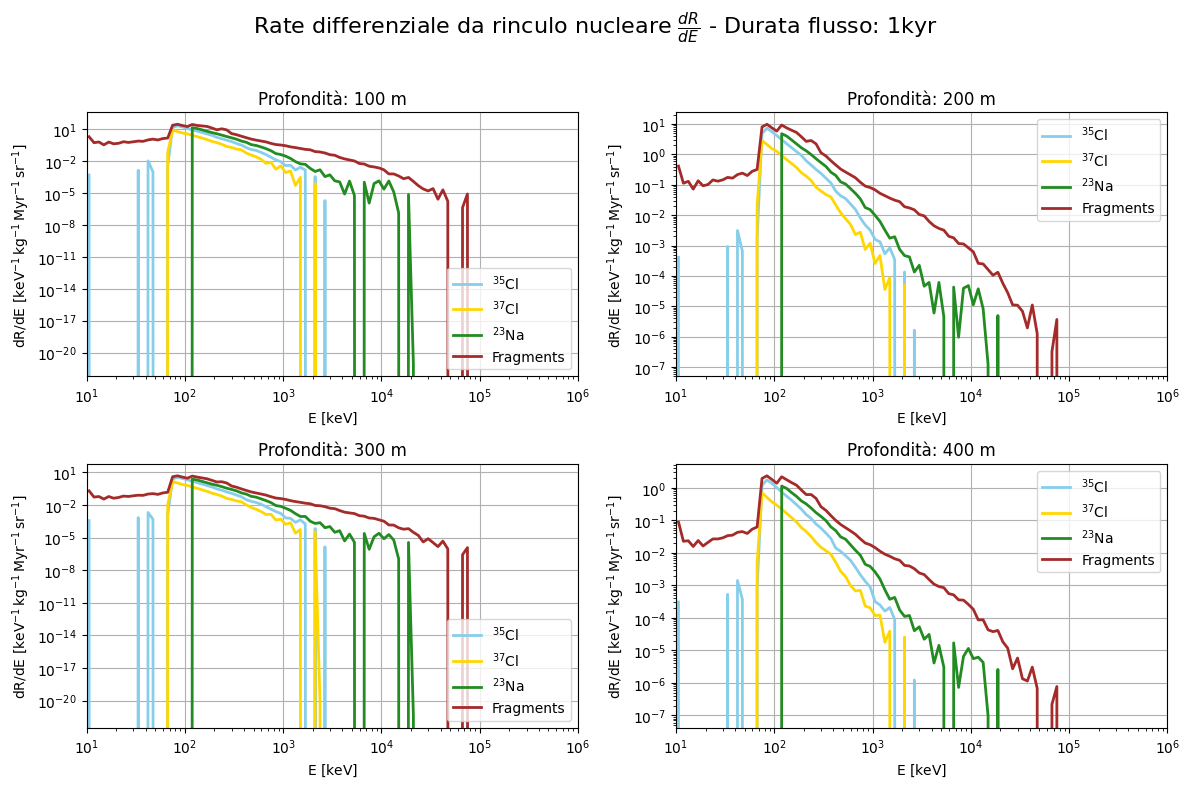

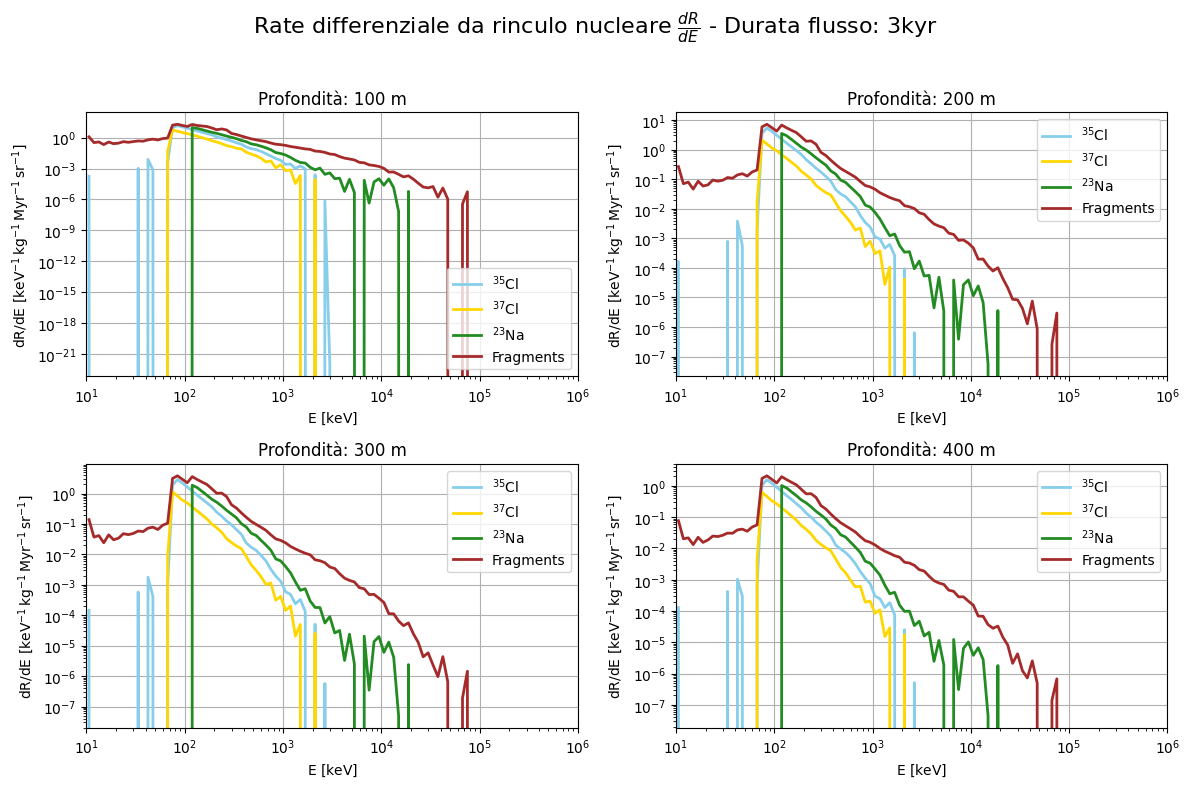

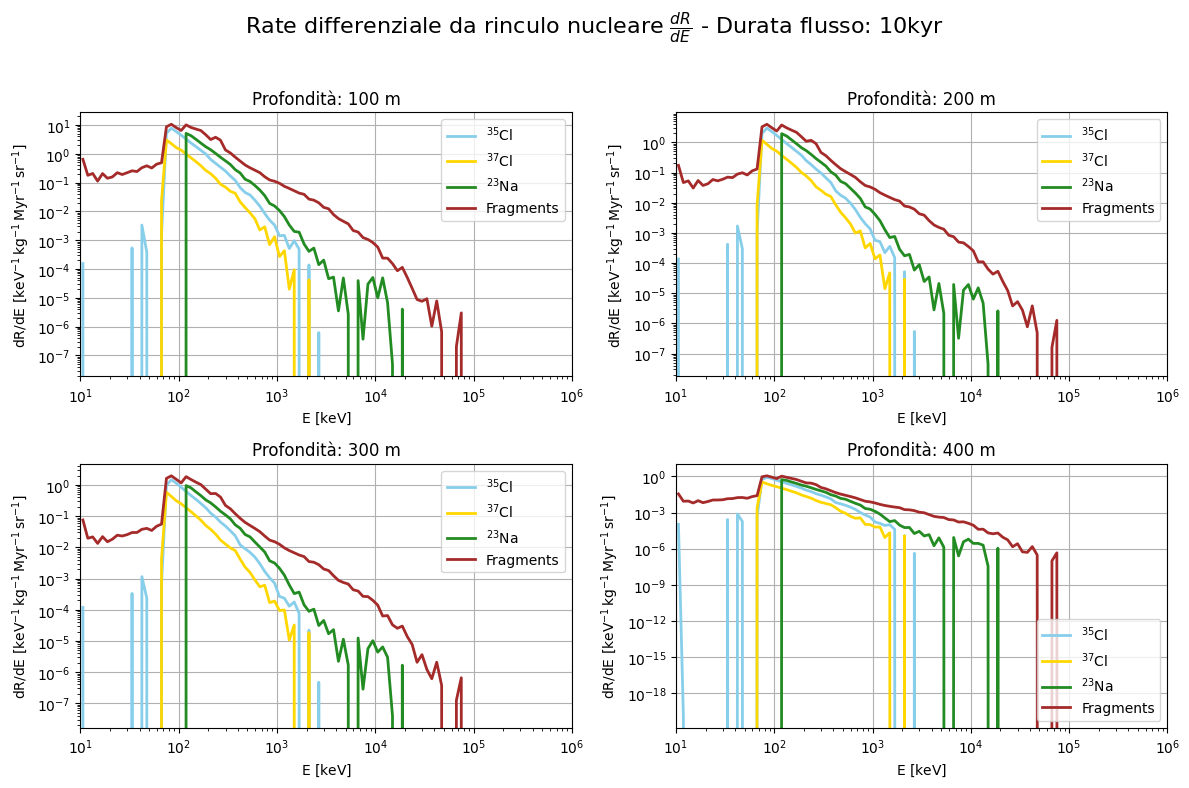

/home/fefe/Thesi/all_you_need/geant/Halite.py:42: RuntimeWarning: divide by zero encountered in log10
  logy = np.log10(yy)


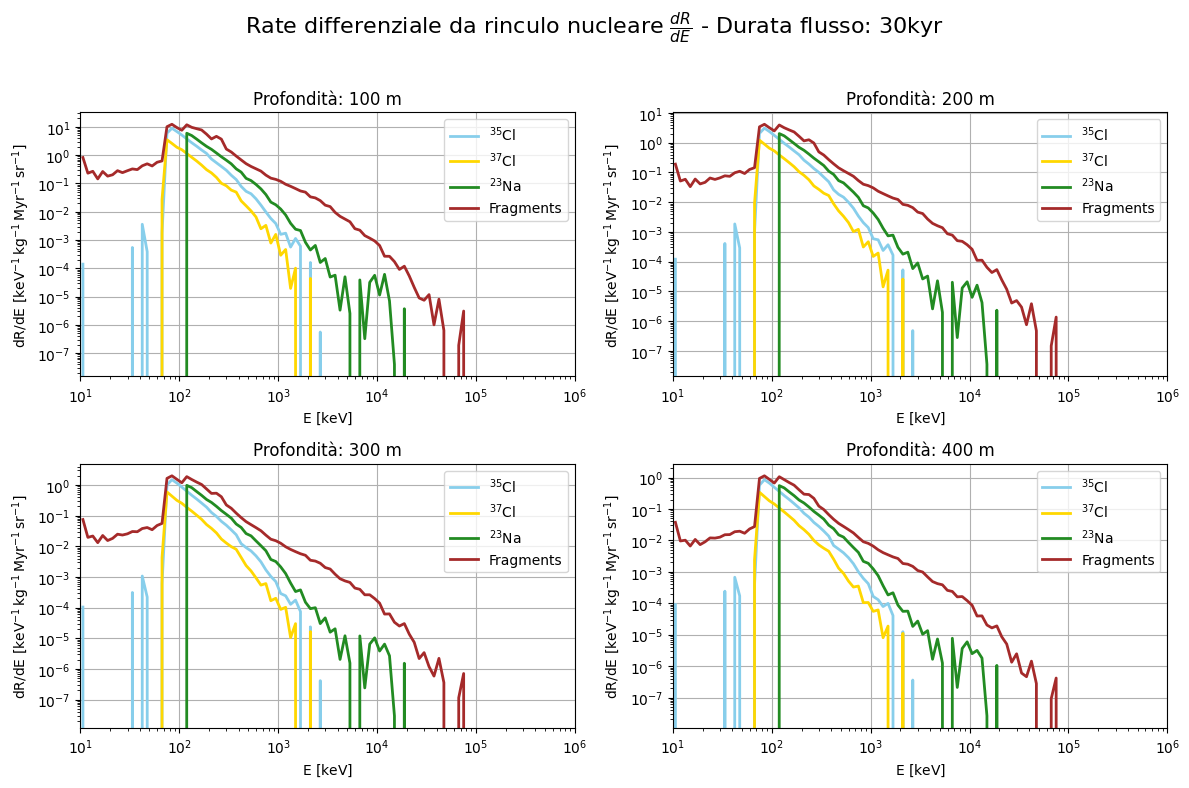

In [71]:
#parametri iniziali
depths = [100, 200, 300, 400]  #profondità dell'alite in metri
depths_kmwe = [d * 1e-3 for d in depths]  #in km.w.e.
Er = np.logspace(-2, 3, 101)  #energia in MeV
time_exposure = 44950 * 365 * 24 * 60 * 60  #tempo di esposizione in secondi 
label_time_fluxes=["100yr", "300yr", "1kyr", "3kyr", "10kyr", "30kyr"] #nome dei file .dat del tempo di durata dei flussi 
time_fluxes = [5e-5, 4.5e-4, 1.35e-3, 3.5e-3, 1.35e-2, 4.5e-2] #intervallo tra un flusso e l'altro in Myr

for i, label in enumerate(label_time_fluxes):
    #carica il flusso iniziale
    x, y = np.loadtxt(f"MuonFluxes/SN20pc{label}.txt", usecols=(0, 1), unpack=True)
    #crea un array di flussi interpolati
    y = y[:-1]/np.diff(x)
    x = x[:-1]
    flux_func = log_interp1d(x, y) #energia in GeV e flusso m-2*s-1*sr-1*Gev-1

    # Crea la figura per la durata corrente
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle(f"Rate differenziale da rinculo nucleare $\\frac{{dR}}{{dE}}$ - Durata flusso: {label}", fontsize=16) 
    

    #simula per ciascuna profondità correggendo i flussi
    for idx, depth in enumerate(depths_kmwe):
        ax = axs[idx // 2, idx % 2]  # Seleziona il subplot corrente

        xx = np.logspace(0, 3, 200)  #energia in GeV
        ee = par(depth) * (xx + 510) - 510 #energia data degli elettroni in keV
        yy = flux_func(ee) * par(depth)
        #flusso ridotto per via della profondità
        reduced_flux = log_interp1d(xx, yy)

        #integra e calcola conteggi
        Num = Integration([reduced_flux], [time_fluxes[i]], time_exposure) #array somma delle energie di tutti i flussi, normalizzato al tempo totale
        Conta = Count(Num, Er)
        
        Er_width = np.diff(Er) #differenza tra un valore dell'array e quella precedente = larghezza del bin
        Er_mid = Er[:-1] + Er_width/2 #punto medio del bin

        Frag = np.zeros(len(Er_mid)) #crea array con tutti i punti medi dei bin di energia
        for k in range (len(Conta[4])): #Count[4]=lunghezza di nuclei
            for l in range(len(Er_mid)):
                Frag[l] += Conta[3][k][l] #somma i bin dei vari nuclei


        F35 = interp1d(Er_mid, Conta[0]/Er_width, fill_value='extrapolate') #interpola in modo log i frammenti dei nuclei di alite
        F37 = interp1d(Er_mid, Conta[1]/Er_width, fill_value='extrapolate')
        F23 = interp1d(Er_mid, Conta[2]/Er_width, fill_value='extrapolate')

        ax.loglog(Er_mid*1e3, F35(Er_mid)*1e-3/(length*rho), label = "$^{35}$Cl", linewidth = 2, color='skyblue') #1000*punto medio del bin, count di quel frammento in quel bin di E (dR/dE)
        ax.loglog(Er_mid*1e3, F37(Er_mid)*1e-3/(length*rho), label = "$^{37}$Cl", linewidth = 2, color='gold')
        ax.loglog(Er_mid*1e3, F23(Er_mid)*1e-3/(length*rho), label = "$^{23}$Na", linewidth = 2, color='forestgreen')        
        ax.loglog(Er_mid*1e3, Frag*1e-3/Er_width/(length*rho), label = 'Fragments', linewidth = 2, color='brown')

        ax.set_xlabel("E [$\\mathrm{keV}$]")
        ax.set_ylabel("dR/dE [$\\mathrm{keV}^{-1}\\,\\mathrm{kg}^{-1}\\,\\mathrm{Myr}^{-1}\\,\\mathrm{sr}^{-1}$]")
        ax.set_title(f"Profondità: {depth * 1e3:.0f} m")
        ax.set_xlim(1e1, 1e6)
        ax.legend()
        ax.grid(True)

    # Aggiusta gli spazi tra i subplot
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Lascia spazio per il titolo generale
    plt.show()


## Calcolo di $\frac{dE}{dx}$ totale sommando i contribuiti di tutti i nuclei

In [51]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

## $\frac{dR}{dx}$ sommando tutti i i-esimi nuclei, pesati, tramite la chain rule

In [52]:
import paleopy as paleopy
from paleopy import *

halite = paleopy.Mineral("Halite")

In [20]:
#variabili

#bin di lunghezza delle tracce
x_bins=calcBins_1nm()
#sezione d'urto
#sigma=4.6e-11 #sezione d'urto dei muoni con Piombo
#Massa della particella (GeV/c²)
m=0.10565 #105.65 Mev
#k è quale tipo di dati sui muoni andare a pescare
#k=0 sono quelli di Resconi
k=7 #quelli di una supernova a 20 pc
#time of exposure
time_exposure = 44950 * 365 * 24 * 60 * 60  #tempo di esposizione in secondi (0.4495 Myr)
#Er bin di energia calcolati sopra
#dRdE calcolati sopra

In [65]:
#check per vedere che il minerale sia quello corretto
#halite.showProperties()
#carica i dati di SRIM per le propietà dell'alite
halite.loadSRIMdata()
#calcolo le tracce nei nuclei
#halite.dRdx_modified(x_bins, Er_mid, dRdE)
#carica le tracce dei neutrini
#lo sto facendo senza separare i contributi delle varie tracce dei neutrini
#halite.dRdx_nu(x_bins)
#aggiungo gli eventi dovuti al Thorio
#forse la prima funzione è commentabile
#time_exposure come quello usaro per dRdE
#halite.xT_Thorium()
#halite.norm_Thorium(time_exposure)
#backgorund di neutroni
#forse qui è dove dovrei aggiungere i miei dati
#halite.loadNeutronBkg()
#halite.dRdx_neutrons(x_bins)
#ok lo sto facendo senza considerare l'acqua
#aggiungo i muoni sott'acqua
#prendo quelli Resconi
#halite.loadMuonWater(k)
#halite.loadMuon_num(k)
#non sto capendo benissimo, ma credo di dover prendere i Muoni con indice 7 nel tag della funzione _num perchè si riferiscono ai muoni dovuti ad una supernova a 20 pc
#halite.dRdx_muons(x_bins, k)

## Plot di $\frac{dR}{dx}$

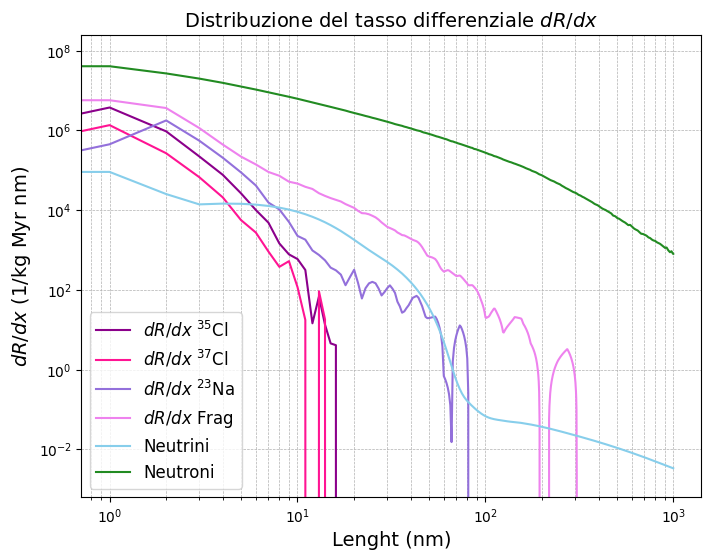

In [70]:
# Calcolo dei dati
#dRdE=[F35(Er_mid)*1e-3/(length*rho), F37(Er_mid)*1e-3/(length*rho), F23(Er_mid)*1e-3/(length*rho), Frag*1e-3/Er_width/(length*rho)]

#x_bins = np.logspace(0, 3, 50)  
z_bins=np.linspace(0,1000, 1000)
y_values35 = halite.dRdx_modified(z_bins, Er_mid, F35(Er_mid)*1e-3/(length*rho)) #il terzo input è dRdE calcolato sopra
y_values37 = halite.dRdx_modified(z_bins, Er_mid, F37(Er_mid)*1e-3/(length*rho)) #il terzo input è dRdE calcolato sopra
y_values23 = halite.dRdx_modified(z_bins, Er_mid, F23(Er_mid)*1e-3/(length*rho)) #il terzo input è dRdE calcolato sopra
y_valuesFrag = halite.dRdx_modified(z_bins, Er_mid, Frag*1e-3/Er_width/(length*rho)) #il terzo input è dRdE calcolato sopra
y_nu = halite.dRdx_nu(z_bins)
y_neutrons = halite.dRdx_neutrons(z_bins) #forse dovrei mettere le tracce che ho calcolato negli Zirconi
#mancano le tracce di Thorio/Uranio

#print("Lunghezza di x_bins:", len(z_bins))
#print("Lunghezza di y_values:", len(y_values35))
#print(x_bins)

# Allinea le lunghezze se necessario
if len(z_bins) != len(y_values35):
    min_len = min(len(z_bins), len(y_values35))
    z_bins = z_bins[:min_len]
    y_values = y_values35[:min_len]

# Crea il plot
plt.figure(figsize=(8, 6))
plt.loglog(z_bins, y_values35, label='$dR/dx$ $^{35}$Cl', color='darkmagenta')
plt.loglog(z_bins, y_values37, label='$dR/dx$ $^{37}$Cl', color='deeppink')
plt.loglog(z_bins, y_values23, label='$dR/dx$ $^{23}$Na', color='mediumpurple')
plt.loglog(z_bins, y_valuesFrag, label='$dR/dx$ Frag', color='violet')
plt.loglog(z_bins, y_nu, label='Neutrini', color='skyblue')
plt.loglog(z_bins, y_neutrons, label='Neutroni', color='forestgreen')

# Configurazione del grafico
plt.xlabel('Lenght (nm)', fontsize=14)
plt.ylabel('$dR/dx$ (1/kg Myr nm)', fontsize=14)
plt.title('Distribuzione del tasso differenziale $dR/dx$', fontsize=14)
#plt.xlim()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(fontsize=12)
plt.show()


### Plot $\frac{dR}{dx}$ per diverse durate del flusso di Muoni

/tmp/ipykernel_285720/2231446941.py:76: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(0, 1e3)


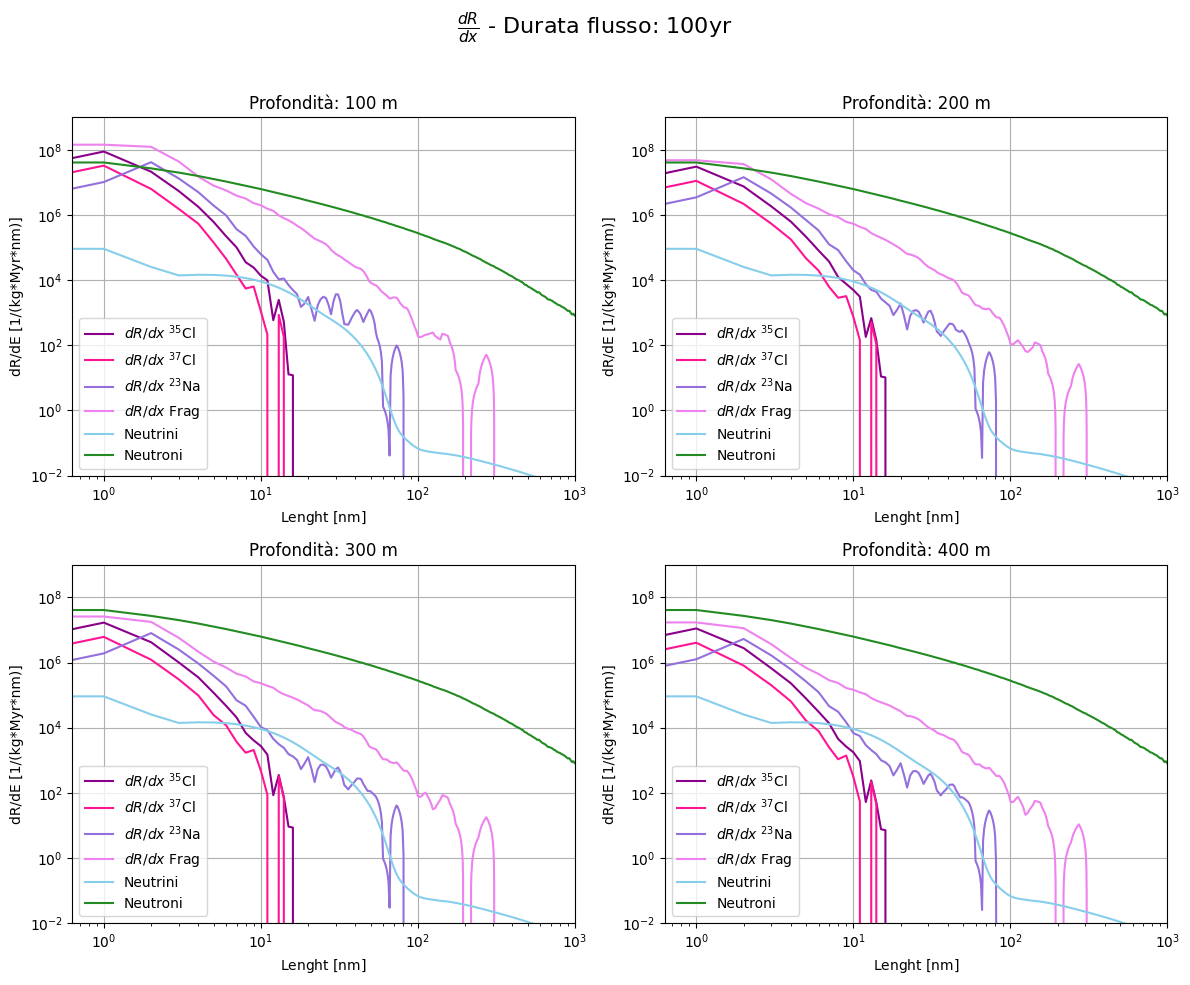

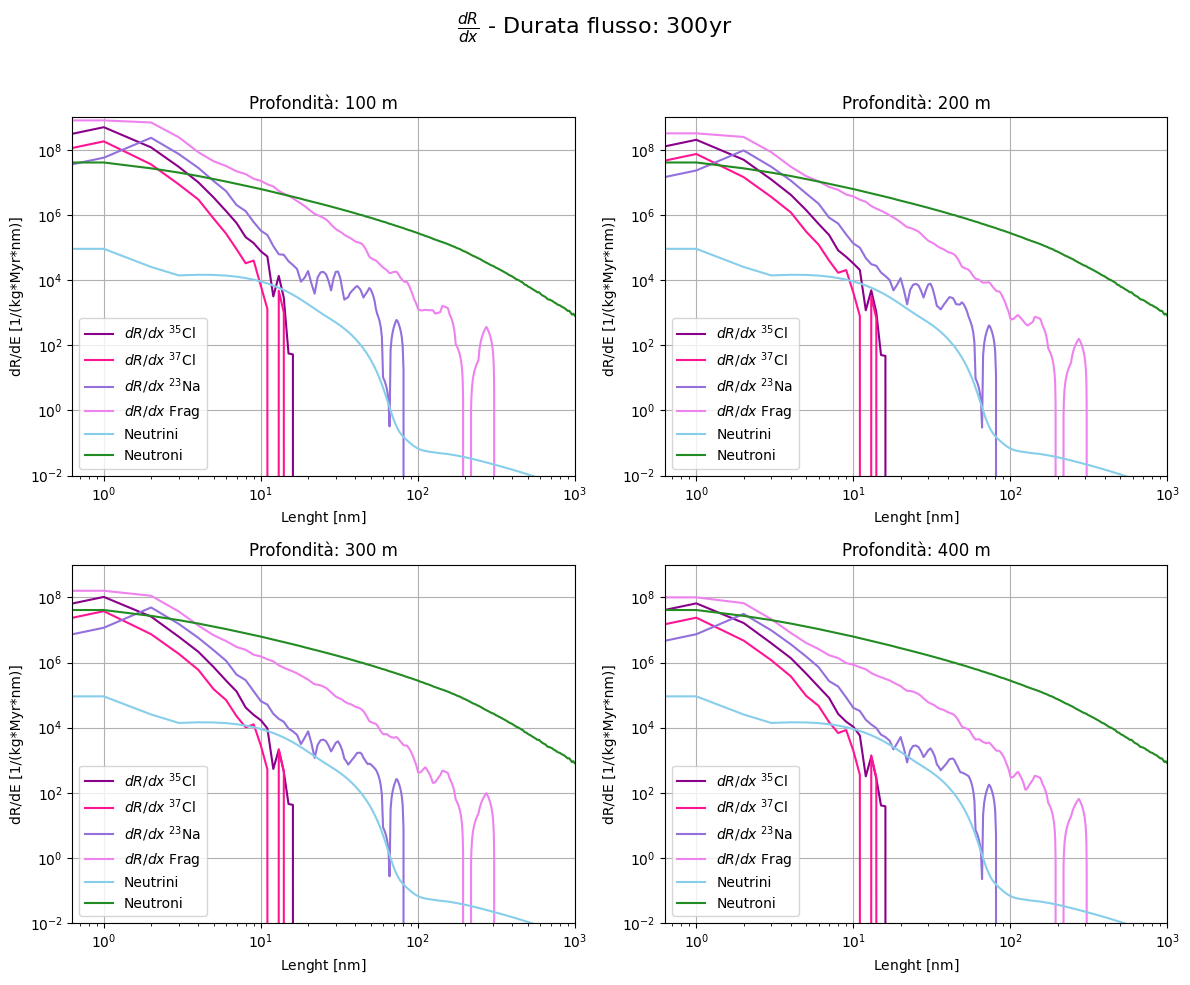

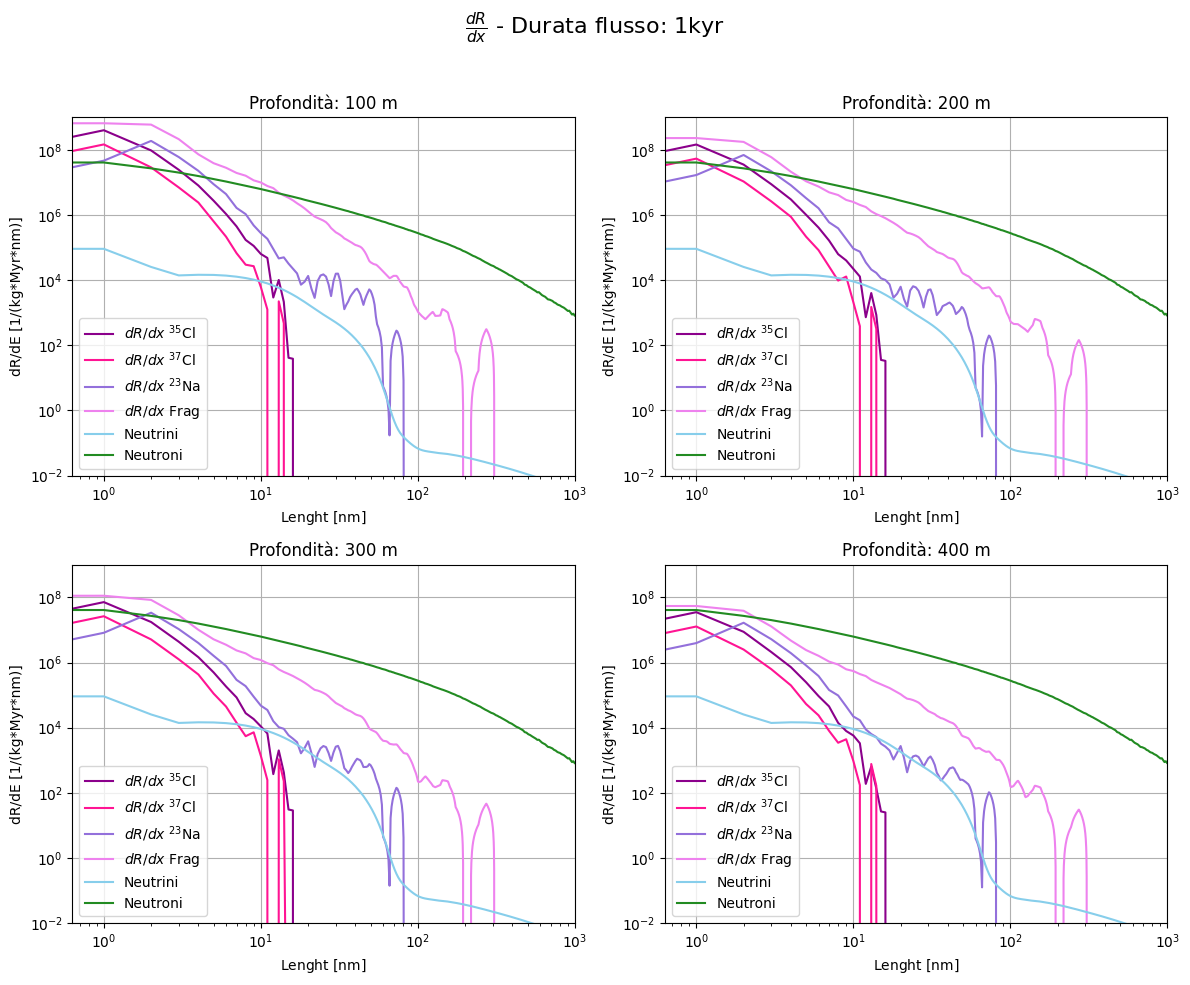

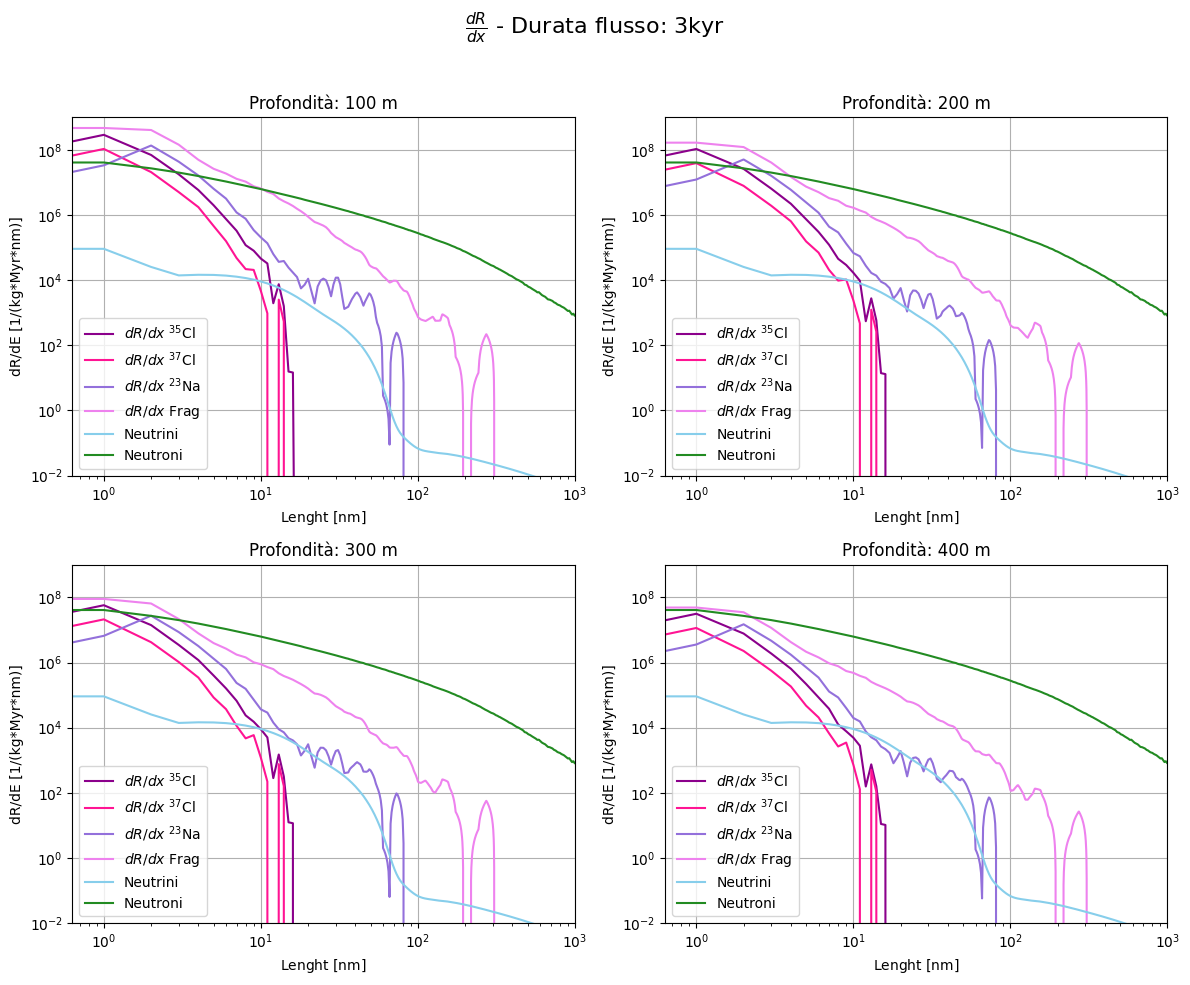

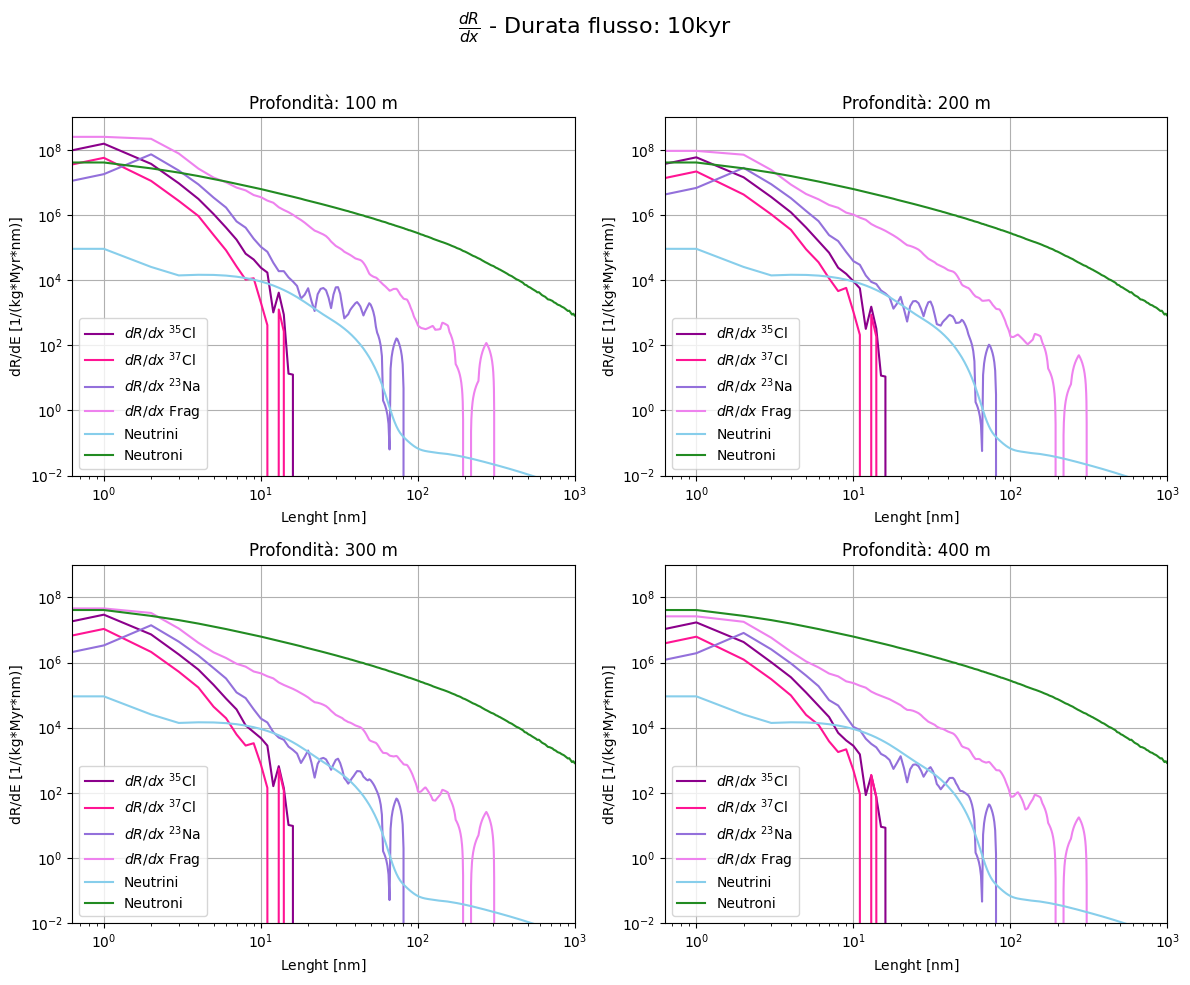

/home/fefe/Thesi/all_you_need/geant/Halite.py:42: RuntimeWarning: divide by zero encountered in log10
  logy = np.log10(yy)


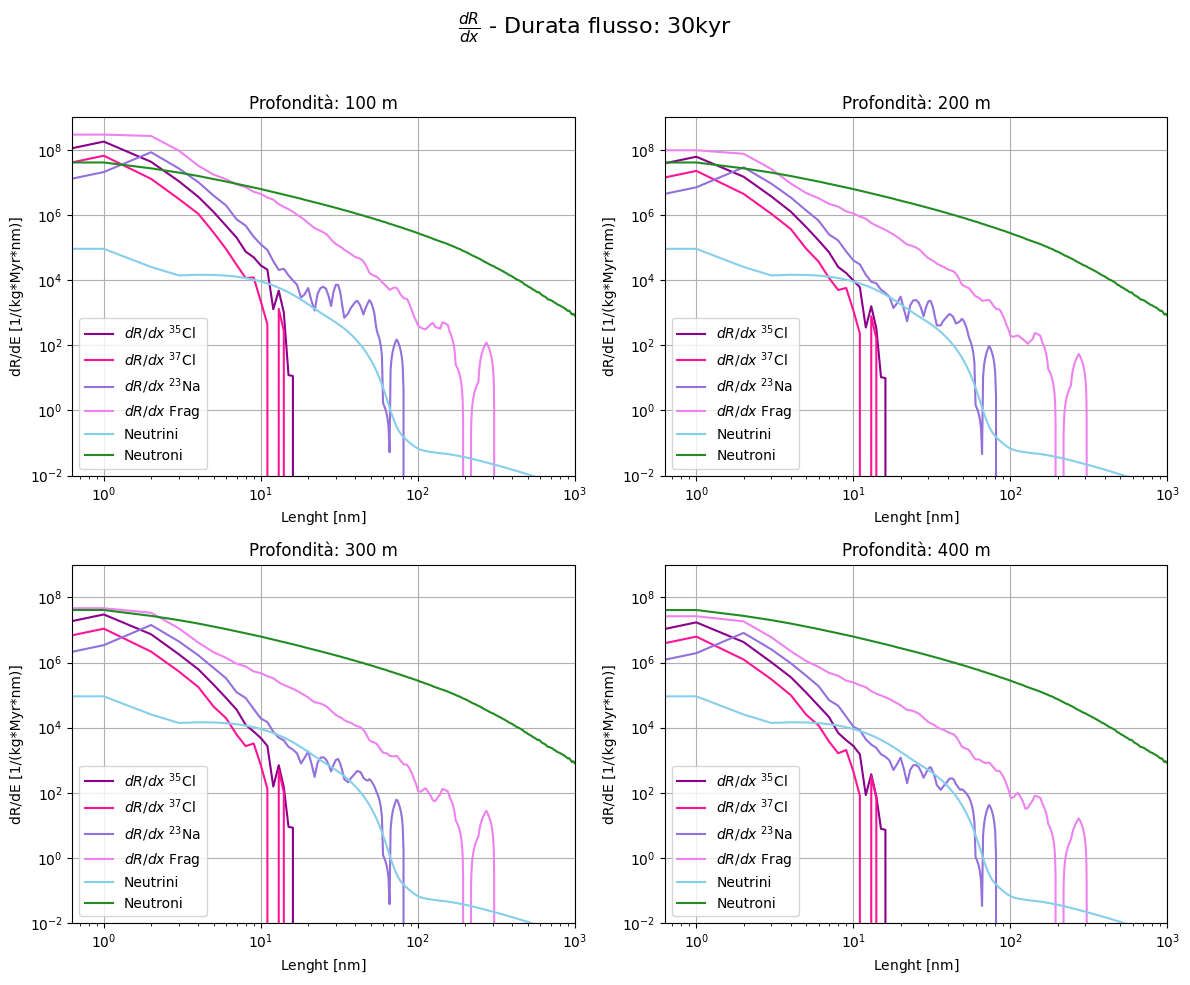

In [77]:
#parametri iniziali
depths = [100, 200, 300, 400]  #profondità dell'alite in metri
depths_kmwe = [d * 1e-3 for d in depths]  #in km.w.e.
Er = np.logspace(-2, 3, 101)  #energia in MeV
time_exposure = 44950 * 365 * 24 * 60 * 60  #tempo di esposizione in secondi 
label_time_fluxes=["100yr", "300yr", "1kyr", "3kyr", "10kyr", "30kyr"] #nome dei file .dat del tempo di durata dei flussi 
time_fluxes = [5e-5, 4.5e-4, 1.35e-3, 3.5e-3, 1.35e-2, 4.5e-2] #intervallo tra un flusso e l'altro in Myr

for i, label in enumerate(label_time_fluxes):
    #carica il flusso iniziale
    x, y = np.loadtxt(f"MuonFluxes/SN20pc{label}.txt", usecols=(0, 1), unpack=True)
    #crea un array di flussi interpolati
    y = y[:-1]/np.diff(x)
    x = x[:-1]
    flux_func = log_interp1d(x, y) #energia in GeV e flusso m-2*s-1*sr-1*Gev-1

    # Crea la figura per la durata corrente
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(f"$\\frac{{dR}}{{dx}}$ - Durata flusso: {label}", fontsize=16) 
    

    #simula per ciascuna profondità correggendo i flussi
    for idx, depth in enumerate(depths_kmwe):
        ax = axs[idx // 2, idx % 2]  # Seleziona il subplot corrente

        xx = np.logspace(0, 3, 200)  #energia in GeV
        ee = par(depth) * (xx + 510) - 510 
        yy = flux_func(ee) * par(depth)
        #flusso ridotto per via della profondità
        reduced_flux = log_interp1d(xx, yy)

        #integra e calcola conteggi
        Num = Integration([reduced_flux], [time_fluxes[i]], time_exposure) #array somma delle energie di tutti i flussi, normalizzato al tempo totale
        Conta = Count(Num, Er)
        
        Er_width = np.diff(Er) #differenza tra un valore dell'array e quella precedente = larghezza del bin
        Er_mid = Er[:-1] + Er_width/2 #punto medio del bin

        Frag = np.zeros(len(Er_mid)) #crea array con tutti i punti medi dei bin di energia
        for k in range (len(Conta[4])): #Count[4]=lunghezza di nuclei
            for l in range(len(Er_mid)):
                Frag[l] += Conta[3][k][l] #somma i bin dei vari nuclei


        F35 = interp1d(Er_mid, Conta[0]/Er_width, fill_value='extrapolate') #interpola in modo log i frammenti dei nuclei di alite
        F37 = interp1d(Er_mid, Conta[1]/Er_width, fill_value='extrapolate')
        F23 = interp1d(Er_mid, Conta[2]/Er_width, fill_value='extrapolate')


        #aggiungo il calcolo di dRdx
        z_bins=np.linspace(0,10000, 10000)
        y_values35 = halite.dRdx_modified(z_bins, Er_mid, F35(Er_mid)*1e-3/(length*rho)) #il terzo input è dRdE calcolato sopra
        y_values37 = halite.dRdx_modified(z_bins, Er_mid, F37(Er_mid)*1e-3/(length*rho)) #il terzo input è dRdE calcolato sopra
        y_values23 = halite.dRdx_modified(z_bins, Er_mid, F23(Er_mid)*1e-3/(length*rho)) #il terzo input è dRdE calcolato sopra
        y_valuesFrag = halite.dRdx_modified(z_bins, Er_mid, Frag*1e-3/Er_width/(length*rho)) #il terzo input è dRdE calcolato sopra
        y_nu = halite.dRdx_nu(z_bins)
        y_neutrons = halite.dRdx_neutrons(z_bins) #forse dovrei mettere le tracce che ho calcolato negli Zirconi

        # Allinea le lunghezze se necessario
        if len(z_bins) != len(y_values35):
            min_len = min(len(z_bins), len(y_values35))
            z_bins = z_bins[:min_len]
            y_values = y_values35[:min_len]

        #plot sugli assi
        ax.loglog(z_bins, y_values35, label='$dR/dx$ $^{35}$Cl', color='darkmagenta')
        ax.loglog(z_bins, y_values37, label='$dR/dx$ $^{37}$Cl', color='deeppink')
        ax.loglog(z_bins, y_values23, label='$dR/dx$ $^{23}$Na', color='mediumpurple')
        ax.loglog(z_bins, y_valuesFrag, label='$dR/dx$ Frag', color='violet')
        ax.loglog(z_bins, y_nu, label='Neutrini', color='skyblue')
        ax.loglog(z_bins, y_neutrons, label='Neutroni', color='forestgreen')

        ax.set_xlabel("Lenght [$\\mathrm{nm}$]")
        ax.set_ylabel("dR/dE [1/(kg*Myr*nm)]")
        ax.set_title(f"Profondità: {depth * 1e3:.0f} m")
        ax.set_xlim(0, 1e3)
        ax.set_ylim(1e-2, 1e9)
        ax.legend()
        ax.grid(True)

    # Aggiusta gli spazi tra i subplot
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Lascia spazio per il titolo generale
    plt.show()
